# 第10回講義 演習

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

rng = np.random.RandomState(1234)

目次

課題. Variational auto-encoder (VAE)によるMNISTの画像生成

1. Variational auto-encoder (VAE)の実装
  - 1.1. MNISTデータセットの読み込み
  - 1.2. VAEの実装
  - 1.3. パラメータの更新設定
  - 1.4. 学習
2. 再構成画像の可視化
  - 2.1. Encoder
  - 2.2. Decoder
  - 2.3. Original image
  - 2.4. Reconstruction image
3. 潜在変数からランダムサンプリング
3. 潜在空間の多様体の可視化

# 課題. Variational auto-encoder (VAE)によるMNISTの画像生成

## 1. Variational auto-encoder (VAE) の実装

### 1.1. MNISTデータセットの読み込み

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
x_valid = (x_valid.reshape(-1, 784) / 255).astype(np.float32)

y_train = np.eye(10)[y_train].astype(np.float32)
y_valid = np.eye(10)[y_valid].astype(np.float32)

### 1.2. VAEの実装

<img src="./../figures/figure1.png" align="left" width="35%" height="35%">

VAEのエンコーダとデコーダは、それぞれ次のように表されます。
- エンコーダ（ガウス分布）：$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}; \mu,\sigma^2{\bf I})$, ただし$\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x})$.
- デコーダ（ベルヌーイ分布）：$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}; \lambda)$, ただし$\lambda=f_{\theta}({\bf z})$.


また、VAEの下界（目的関数）は次のとおりです。

${\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]$

第1項が（負の）再構成誤差、第2項が正則化項に対応しています。

- 第1項は、次のように計算できます。

  $E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]=\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})$,  ただし$ {\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})$.

  なおデコーダはベルヌーイ分布なので、右辺は次のように計算できます。
  
  $\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)$,  ただし$\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})$.  
  （実装内の`reconstruction`に対応）


- また第2項については、次のように解析的に計算できます（ただし、$p_{\theta}({\bf z})={\cal N}(0,{\bf I})$とする）。
  $D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2)-(\mu_j)^2-(\sigma_j)^2)$  
  （実装内の`KL`に対応）

In [4]:
tf.reset_default_graph()
z_dim = 10

def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

def encoder(x):
    with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
        h1 = tf.layers.Dense(units=200, activation=tf.nn.relu)(x)
        h2 = tf.layers.Dense(units=200, activation=tf.nn.relu)(h1)
        mean = tf.layers.Dense(units=z_dim)(h2)
        var = tf.layers.Dense(units=z_dim, activation=tf.nn.softplus)(h2)
    return mean, var

def sampling_z(mean, var):
    epsilon = tf.random_normal(shape=tf.shape(mean))
    z = mean + tf.sqrt(var) * epsilon
    return z

def decoder(z):
    with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
        h3 = tf.layers.Dense(units=200, activation=tf.nn.relu)(z)
        h4 = tf.layers.Dense(units=200, activation=tf.nn.relu)(h3)
        y = tf.layers.Dense(units=784, activation=tf.nn.sigmoid)(h4)
    return y

def lower_bound(x):
    #Encode
    mean, var = encoder(x)
    KL = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + tf_log(var) - mean**2 - var, axis=1))
    
    #Z
    z = sampling_z(mean, var)
    
    #Decode
    y = decoder(z)
    reconstruction = tf.reduce_mean(tf.reduce_sum(x * tf_log(y) + (1 - x) * tf_log(1 - y), axis=1))
    
    lower_bound = [-KL, reconstruction]
    
    return lower_bound

### 1.3. パラメータの更新設定

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
lower_bound = lower_bound(x)

cost = -tf.reduce_sum(lower_bound) # 下界を最大化するため、マイナスをとる
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(cost)

valid = tf.reduce_sum(lower_bound)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### 1.4. 学習

In [6]:
batch_size =100

n_batches = x_train.shape[0] // batch_size
n_epochs = 15

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(n_epochs):
    rng.shuffle(x_train)
    lower_bound_all = []
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        _, lowerbound = sess.run([train, lower_bound], feed_dict={x: x_train[start:end]})
        lower_bound_all.append(lowerbound)
    lower_bound_all = np.mean(lower_bound_all, axis=0)
    lower_bound_valid = sess.run(valid, feed_dict={x: x_valid[0:100]})
    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
          (epoch+1, np.sum(lower_bound_all), lower_bound_all[0], lower_bound_all[1], lower_bound_valid))

EPOCH:1, Train Lower Bound:-167.258850, (-11.024315, -156.234543), Valid Lower Bound:-130.882401
EPOCH:2, Train Lower Bound:-126.975899, (-15.784286, -111.191612), Valid Lower Bound:-118.578552
EPOCH:3, Train Lower Bound:-119.969414, (-16.678886, -103.290527), Valid Lower Bound:-114.491638
EPOCH:4, Train Lower Bound:-116.478889, (-17.097204, -99.381683), Valid Lower Bound:-111.485733
EPOCH:5, Train Lower Bound:-114.165321, (-17.385468, -96.779854), Valid Lower Bound:-110.471100
EPOCH:6, Train Lower Bound:-112.485794, (-17.570648, -94.915146), Valid Lower Bound:-109.910072
EPOCH:7, Train Lower Bound:-111.209648, (-17.723961, -93.485687), Valid Lower Bound:-107.467880
EPOCH:8, Train Lower Bound:-110.179710, (-17.834059, -92.345650), Valid Lower Bound:-106.864098
EPOCH:9, Train Lower Bound:-109.381966, (-17.936518, -91.445450), Valid Lower Bound:-105.979874
EPOCH:10, Train Lower Bound:-108.665031, (-17.980097, -90.684937), Valid Lower Bound:-105.488052
EPOCH:11, Train Lower Bound:-108.072

## 2. 再構成画像の可視化

### 2.1. Encoder

In [7]:
x = tf.placeholder(tf.float32, [None, 784])
sample_z_func = encoder(x) # mean, var

### 2.2. Decoder

In [8]:
z = tf.placeholder(tf.float32, [None, z_dim])
sample_x_func = decoder(z) # mean

### 2.3. Original image

In [9]:
def deprocess(x):
    _x = x.reshape(x.shape[0], 28, 28)
    return 1 - _x

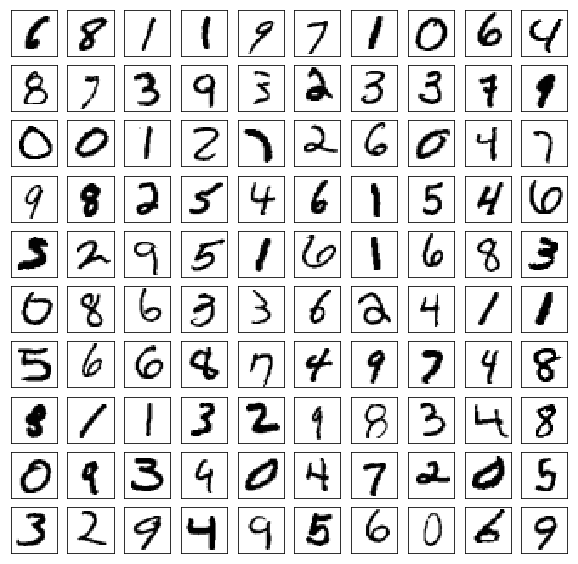

In [10]:
n_samples = 100

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(x_train[:n_samples])

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

### 2.4. Reconstruction image

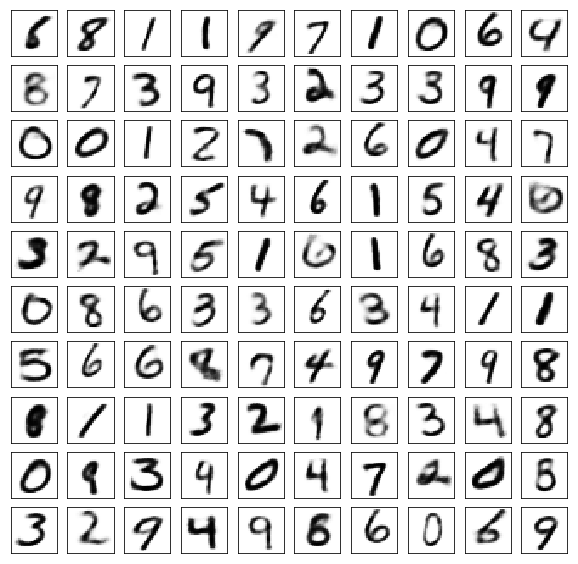

In [11]:
# Encode
mean, var = sess.run(sample_z_func, feed_dict={x: x_train[:n_samples]})
sample_z = mean

# Decode
sample_x = sess.run(sample_x_func, feed_dict={z: sample_z})

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_x)

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

## 3. 潜在変数からランダムサンプリング

- z_dimを変更したときのサンプルを比較しよう

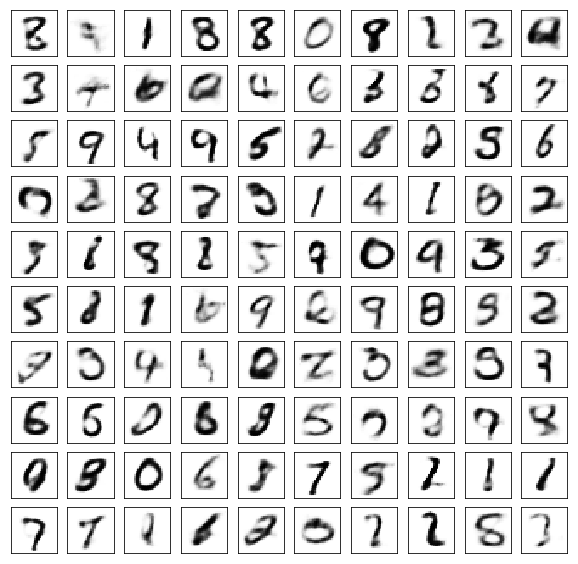

In [12]:
sample_z = np.random.standard_normal((n_samples, z_dim)).astype('float32')
sample_z = sess.run(sample_x_func, feed_dict={z: sample_z})

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_z)

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

## 4. 潜在空間の多様体の可視化

- データ間を遷移して、潜在空間で多様体構造が学習できていることを確認しよう

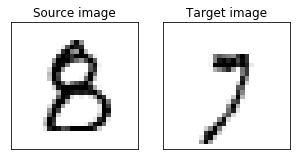

In [18]:
# Source
x_0 = x_train[10:11]

# Target
x_1 = x_train[11:12]

fig = plt.figure(figsize=(5, 5))
ax_0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax_0.set_title('Source image')
ax_0.imshow(deprocess(x_0)[0], 'gray')

ax_1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax_1.set_title('Target image')
ax_1.imshow(deprocess(x_1)[0], 'gray')

plt.show()

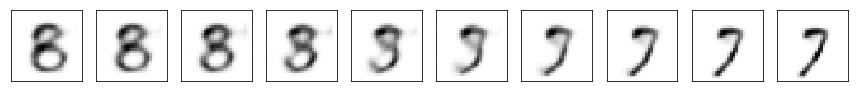

In [19]:
# 潜在空間に写像
sample_z_0, _ = sess.run(sample_z_func, feed_dict={x: x_0})
sample_z_1, _ = sess.run(sample_z_func, feed_dict={x: x_1})

move = sample_z_1 - sample_z_0

fig = plt.figure(figsize=(15, 15))

for i, j in enumerate(np.linspace(0, 1, 10)):
    # 線形補間
    _z = sample_z_0 + j*move
    sample_x = sess.run(sample_x_func, feed_dict={z: _z})

    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(sample_x)[0], 'gray')